In [39]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

from sde.sde_learning_network_modified import (
    TimingCallback,
    SDEIdentification,
    ModelBuilder,
    SDEApproximationNetwork,
)

from sde.experiment_reports_owen import (
    PlotResults,
    sample_data
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# notebook parameters
n_dimensions = 1
step_size = 1e-2
n_pts = 10000
n_subsample = 10

random_seed = 1


In [56]:
# network parameters
n_layers = 1
n_dim_per_layer = 2**7

#ACTIVATIONS = tf.nn.elu
def ACTIVATIONS(x):
    j = tf.constant(1j, dtype=tf.complex64)
    x = tf.cast(x, dtype=tf.complex64)
    return tf.exp(j * x)
VALIDATION_SPLIT = .1
BATCH_SIZE = 2**3
LEARNING_RATE = 1e-3
N_EPOCHS = 200

diffusivity_type = "diagonal"

In [57]:
# generate training data
def true_drift(x):
    result = -(4 * x**3 - 8 * x + 3) / 2
    return result.reshape(-1, 1)


def true_diffusion(x):
    result = (0.1 * x + 1) * 0.5
    return result.reshape(-1, 1)


def true_drift_diffusion(x):
    return true_drift(x), true_diffusion(x)


xlim = np.array([[-2, 2]])

step_sizes = np.zeros((x_data.shape[0],)) + step_size


In [58]:
# train model
No_of_tests = 1
training_time = np.zeros((No_of_tests, N_EPOCHS))
val_loss = np.zeros((No_of_tests, N_EPOCHS))

for i in range(No_of_tests):
    rng = np.random.default_rng(random_seed+i)
    tf.random.set_seed(random_seed+i)

    # generate data
    x_data, y_data, _ = sample_data(true_drift_diffusion, step_size, n_pts, n_subsample, rng, xlim)

    # build network
    encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
    model = SDEApproximationNetwork(sde_model=encoder, method="euler")
    model.compile(optimizer=tf.keras.optimizers.Adamax())
    sde_i = SDEIdentification(model=model)
    timing_callback = TimingCallback()

    # train network
    hist, _ = sde_i.train_model(x_data, y_data, step_size=step_sizes, validation_split=VALIDATION_SPLIT, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, callbacks=[timing_callback])
    
    training_time[i,:] = timing_callback.epoch_times
    val_loss[i,:] = hist.history["val_loss"]




training for 200 epochs with 9000 data points, validating with 1000


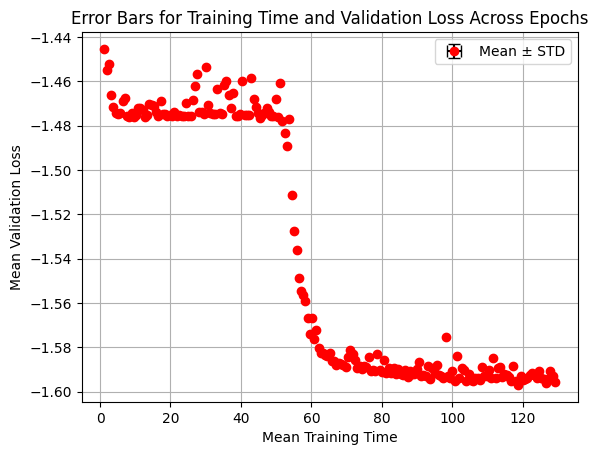

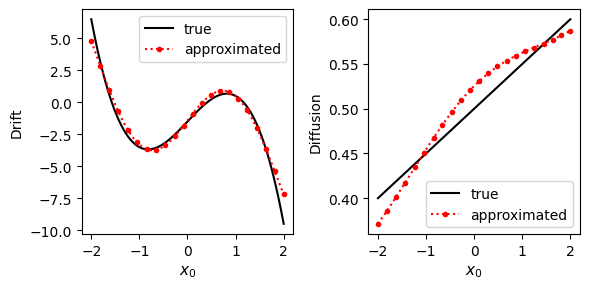

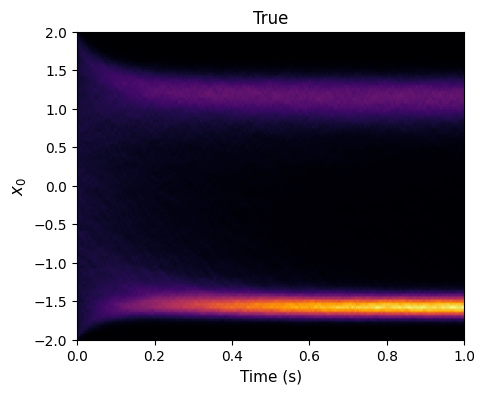

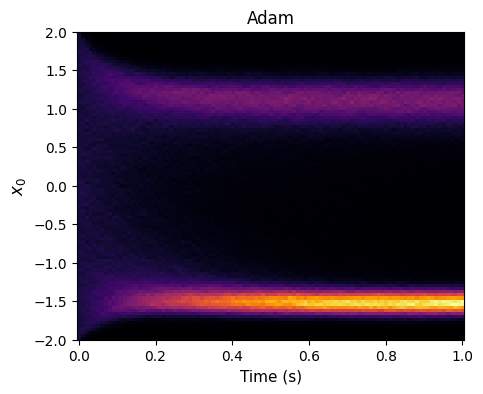

In [59]:
# display and save plots
PR = PlotResults(script_dir=script_dir, filename=filename, n_subsample=n_subsample)

PR.loss_v_time(training_time, val_loss, save=False)

PR.plot_results_functions(sde_i.drift_diffusivity, true_drift_diffusion, x_data, save=False)

time = 100*step_size
PR.plot_histogram(true_drift_diffusion, step_size/n_subsample, time, rng, xlim, name='True', save=False)
PR.plot_histogram(sde_i.drift_diffusivity, step_size, time, rng, xlim, name='Adam', save=False)


In [44]:
encoder.summary()

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GP_inputs (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 GP_mean_hidden_0 (Dense)       (None, 128)          256         ['GP_inputs[0][0]']              
                                                                                                  
 GP_std_hidden_0 (Dense)        (None, 128)          256         ['GP_inputs[0][0]']              
                                                                                                  
 GP_output_mean (Dense)         (None, 1)            129         ['GP_mean_hidden_0[0][0]']       
                                                                                

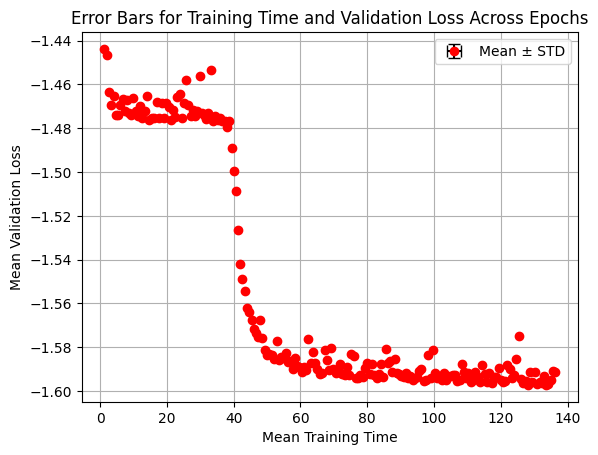

In [45]:
# Initialize arrays to store results
mean_training_time = np.zeros(N_EPOCHS)
mean_val_loss = np.zeros(N_EPOCHS)
std_training_time_above = np.zeros(N_EPOCHS)
std_training_time_below = np.zeros(N_EPOCHS)
std_val_loss_above = np.zeros(N_EPOCHS)
std_val_loss_below = np.zeros(N_EPOCHS)

# Iterate over epochs
for epoch in range(N_EPOCHS):
    training_time = cumulative_times[:, epoch]
    val_loss = val_losses[:, epoch]

    # Calculate mean
    mean_training_time[epoch] = np.mean(training_time)
    mean_val_loss[epoch] = np.mean(val_loss)

    # Calculate deviations for training_time
    training_time_above = training_time[training_time > mean_training_time[epoch]] - mean_training_time[epoch]
    training_time_below = mean_training_time[epoch] - training_time[training_time < mean_training_time[epoch]]
    std_training_time_above[epoch] = np.std(np.concatenate((training_time_above, -training_time_above)))
    std_training_time_below[epoch] = np.std(np.concatenate((training_time_below, -training_time_below)))

    # Calculate deviations for val_loss
    val_loss_above = val_loss[val_loss > mean_val_loss[epoch]] - mean_val_loss[epoch]
    val_loss_below = mean_val_loss[epoch] - val_loss[val_loss < mean_val_loss[epoch]]
    std_val_loss_above[epoch] = np.std(np.concatenate((val_loss_above, -val_loss_above)))
    std_val_loss_below[epoch] = np.std(np.concatenate((val_loss_below, -val_loss_below)))

plt.errorbar(
    mean_training_time, mean_val_loss,
    xerr=[std_training_time_below, std_training_time_above],  # Non-symmetrical x error
    yerr=[std_val_loss_below, std_val_loss_above],  # Non-symmetrical y error
    fmt='o', color='red', ecolor='black', elinewidth=1.5, capsize=4, label='Mean ± STD'
)

plt.xlabel('Mean Training Time')
plt.ylabel('Mean Validation Loss')
plt.title('Error Bars for Training Time and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)

In [26]:
# export data
data = pd.DataFrame({
    "cum_time": mean_training_time,
    "loss": mean_val_loss,
    "std_training_time_above": std_training_time_above,
    "std_training_time_below": std_training_time_below,
    "std_val_loss_above": std_val_loss_above,
    "std_val_loss_below": std_val_loss_below
})

output_dir = os.path.join(script_dir, 'loss_data')
output_path = os.path.join(output_dir, "example3 - 1d sde-cubic data.csv")
data.to_csv(output_path, index=False)